In [1]:
import sys
sys.path.append("../src")

import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from utils import get_dataset, Encoder

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cache_dir = os.path.join("..", "data")
split = "train"

train_dataset = get_dataset(cache_dir=cache_dir, split=split)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [3]:
len(train_dataset)

1281167

In [4]:
batch = next(iter(train_loader))

batch.keys()

dict_keys(['image', 'label'])

In [5]:
batch["image"].keys()

dict_keys(['global_crops', 'local_crops'])

In [6]:
views = batch["image"]

global_crops = views["global_crops"]
local_crops = views["local_crops"]

In [7]:
global_crop0 = global_crops[0]
global_crop1 = global_crops[1]

local_crop0 = local_crops[0]
local_crop1 = local_crops[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


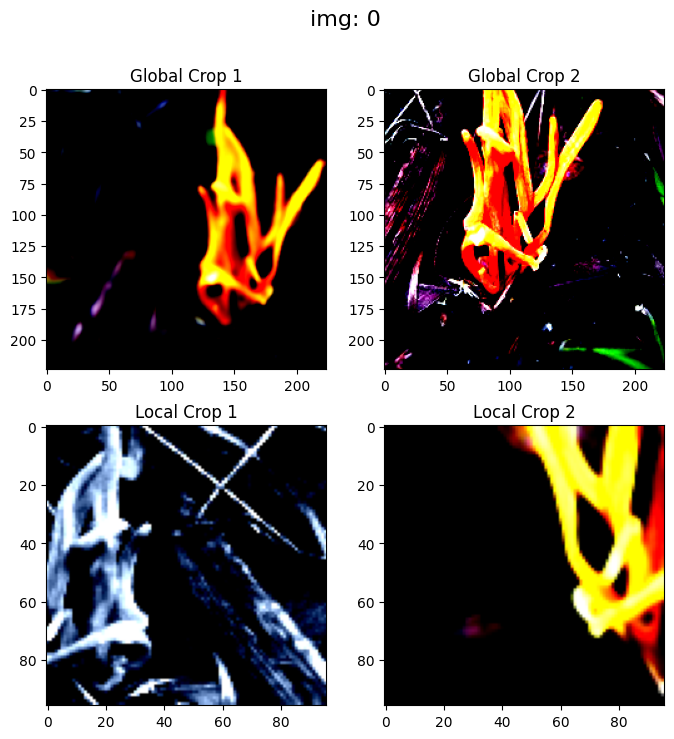

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


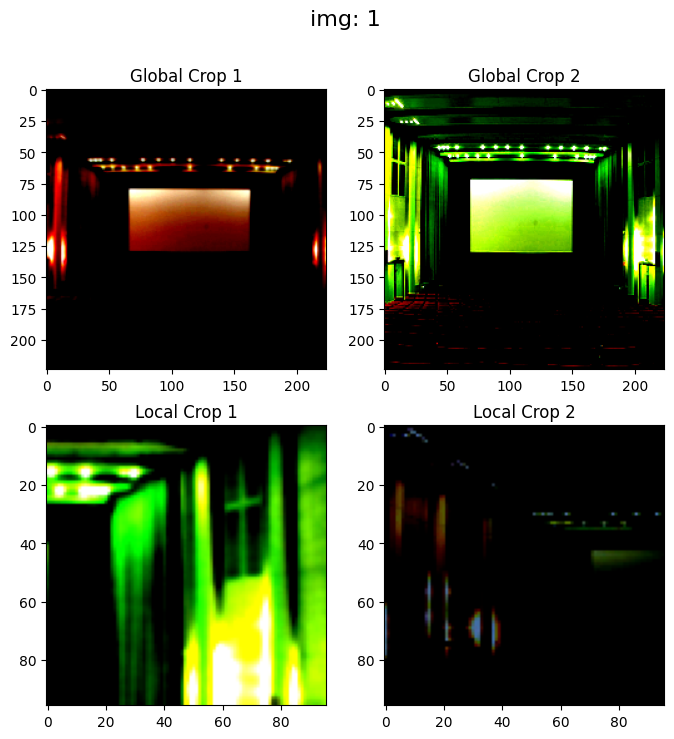

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


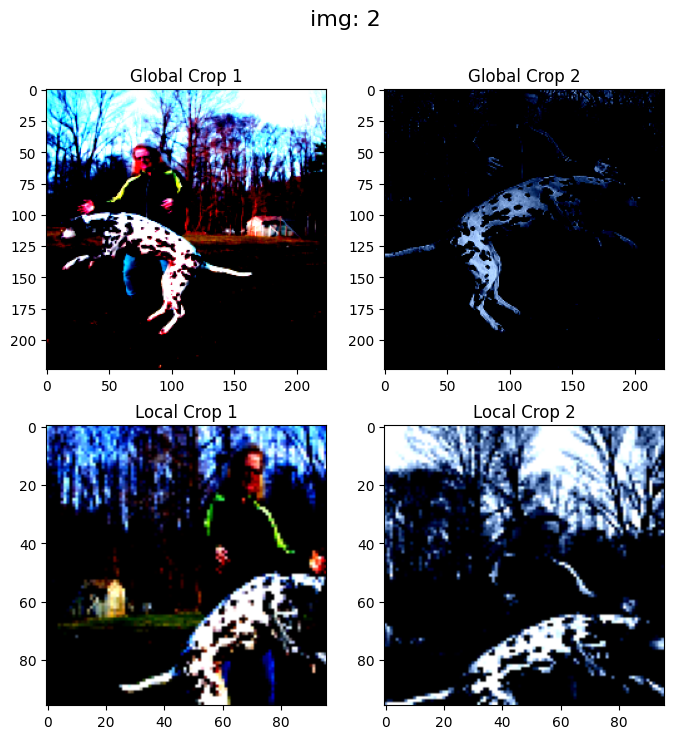

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


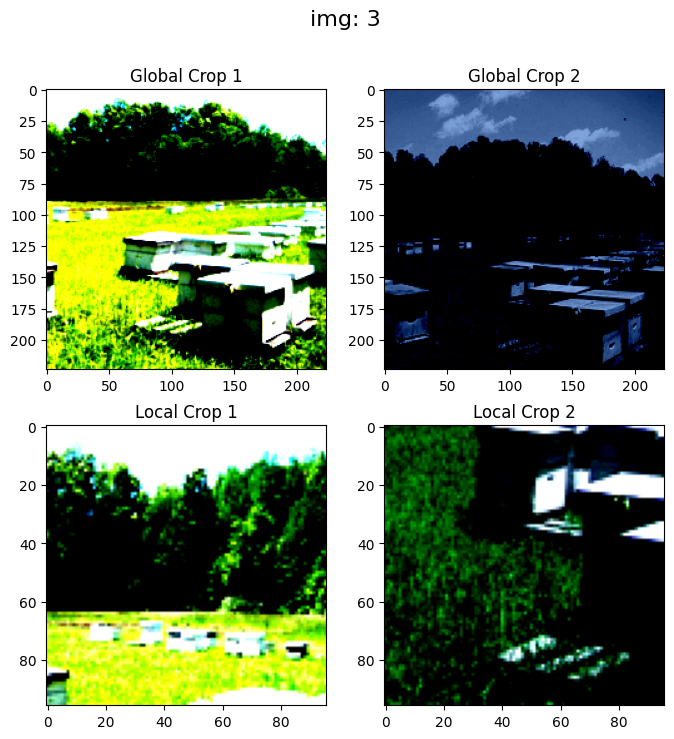

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


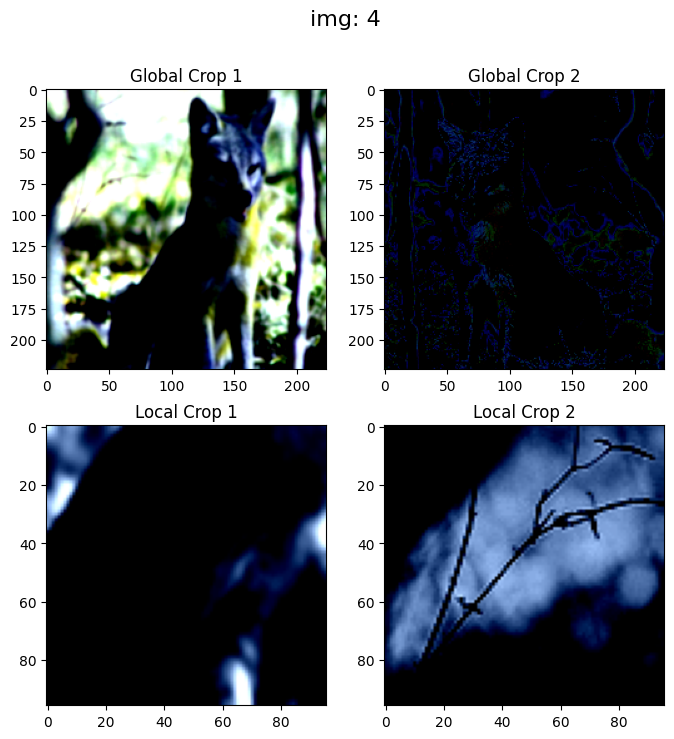

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


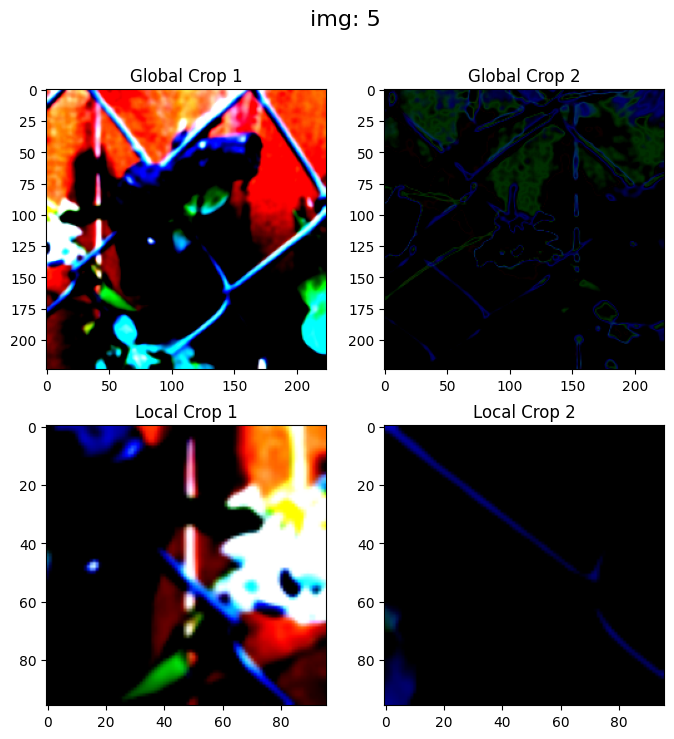

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


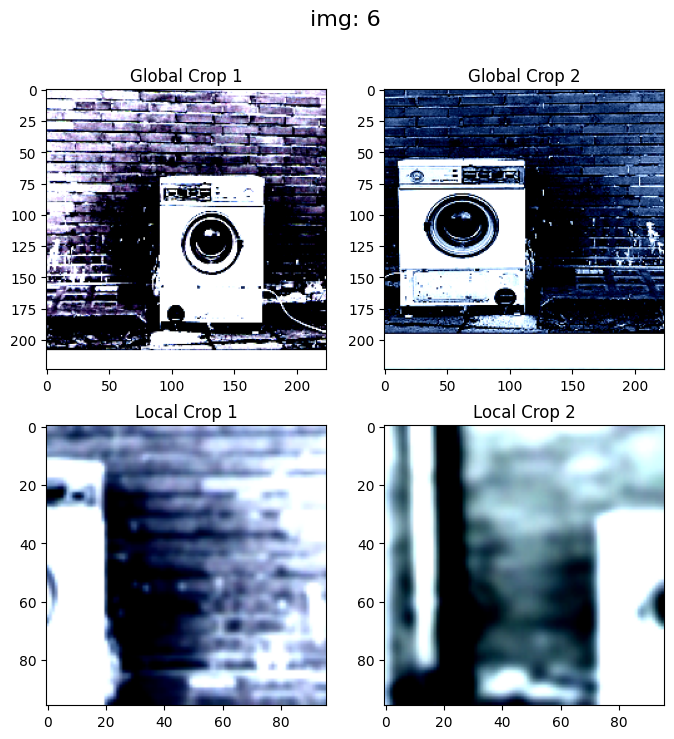

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


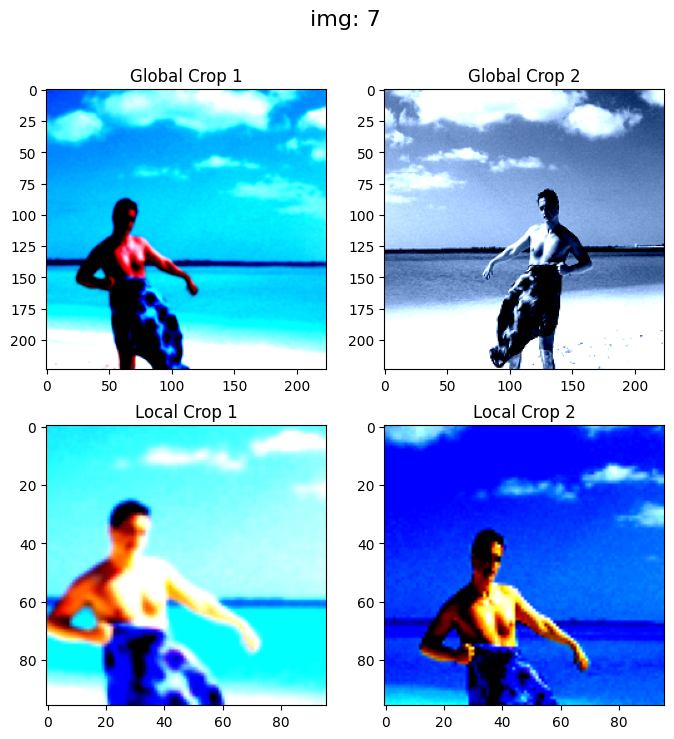

In [8]:
for idx in range(len(global_crop0)):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(f"img: {idx}", fontsize=16)

    axes[0][0].imshow(global_crop0[idx].permute(1,2,0).numpy())
    axes[0][0].set_title("Global Crop 1")

    axes[0][1].imshow(global_crop1[idx].permute(1,2,0).numpy())
    axes[0][1].set_title("Global Crop 2")

    axes[1][0].imshow(local_crop0[idx].permute(1,2,0).numpy())
    axes[1][0].set_title("Local Crop 1")

    axes[1][1].imshow(local_crop1[idx].permute(1,2,0).numpy())
    axes[1][1].set_title("Local Crop 2")

    plt.show()

In [9]:
def center_outputs(
    teacher_out: torch.Tensor,
    center: torch.Tensor,
    momentum: float
    ) -> torch.Tensor:
    
    center = momentum * center + (1 - momentum) * torch.mean(teacher_out, dim=0, keepdim=True)
    
    teacher_out = teacher_out - center
    
    return teacher_out

In [10]:
teacher = Encoder("vit-s-16")
for param in teacher.parameters():
    param.requires_grad = False

student = Encoder("vit-s-16")

In [11]:
@torch.no_grad()
def update_teacher(teacher, student, momentum):
    for param_t, param_s in zip(teacher.parameters(), student.parameters()):
        param_t.data.mul_(momentum).add_((1 - momentum) * param_s.data)

In [12]:
for param in teacher.parameters():
    print(param)

Parameter containing:
tensor([[[-1.2937e-06,  2.4376e-07, -1.3645e-06,  9.7002e-07,  1.1634e-06,
           6.8976e-08,  9.2566e-08, -2.5691e-06,  1.2620e-06,  9.8764e-07,
          -2.3639e-06, -8.4669e-07,  6.6163e-07,  2.1088e-07, -1.0390e-06,
          -9.5540e-07, -1.2665e-06,  4.2862e-07,  4.3668e-07, -6.7694e-07,
          -3.2245e-08, -1.2406e-06,  7.2677e-07, -5.5054e-08, -7.8938e-07,
          -1.5062e-07, -6.5963e-07,  5.6657e-07, -3.0933e-07, -9.6360e-07,
          -1.4733e-06, -2.4513e-06, -2.5475e-07, -9.3220e-07, -5.4836e-07,
           3.4201e-07,  1.0444e-06, -2.8526e-07, -3.3348e-07, -4.1765e-07,
          -9.3046e-07, -1.0166e-06, -5.2617e-07, -6.9310e-07, -7.7546e-07,
          -2.1770e-06,  8.2315e-07,  1.8455e-06,  5.3900e-07, -3.8659e-07,
          -1.3195e-06,  1.4497e-06,  1.3810e-06, -1.0342e-06, -8.0661e-09,
           4.1297e-07, -6.4898e-07, -1.4247e-06, -3.7538e-07, -4.0971e-07,
          -2.2444e-07, -5.4046e-07,  1.0932e-07, -6.8836e-07,  8.1137e-07,
   

In [13]:
def get_param_groups(encoder):
    regularized = []
    not_regularized = []

    for name, param in encoder.named_parameters():
        if param.requires_grad:
            if name.endswith(".bias") or len(param.shape) == 1:
                not_regularized.append(param)

            else:
                regularized.append(param)

    param_groups = [
        {"params": regularized},
        {"params": not_regularized, "weight_decay": 0.0}
    ]

    return param_groups

In [14]:
param_groups = get_param_groups(student)

# param_groups

In [15]:
optimizer = torch.optim.AdamW(param_groups)

len(optimizer.param_groups)

2

In [16]:
# update_teacher(teacher, student, momentum=1)

# for param in teacher.parameters():
#     print(param)

In [22]:
student

Encoder(
  (encoder): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
  

In [17]:
with torch.inference_mode():
    teacher_outs = {
        "g0": teacher(global_crop0),
        "g1": teacher(global_crop1)
    }

student_outs = {
    "g0": student(global_crop0),
    "g1": student(global_crop1)
}
for i, crop in enumerate(local_crops):
    student_out = student(crop)
    student_outs[f"l{i}"] = student_out

In [18]:
print("g0 shape:", teacher_outs["g0"].shape)
print("g1 shape:", teacher_outs["g1"].shape)

g0 shape: torch.Size([8, 65536])
g1 shape: torch.Size([8, 65536])


In [19]:
torch.cat([v for _, v in teacher_outs.items()], dim=0).shape

torch.Size([16, 65536])

In [20]:
center = 0
centered = center_outputs(teacher_out, center, momentum=0.9)

centered.shape

NameError: name 'teacher_out' is not defined

In [143]:
epochs = 1
num_warmup_epochs = 1
teacher_temp = (0.04, 0.07)

temperatures = np.concatenate([
    np.linspace(
        start=teacher_temp[0], 
        stop=teacher_temp[1],
        num=num_warmup_epochs
    ), np.ones(epochs - num_warmup_epochs) * teacher_temp[1]
    ])

len(temperatures)

1

In [145]:
student_temp = 0.1

for epoch in range(0, epochs):
    teacher_temp = temperatures[epoch]

    total_loss = 0 # accumulated loss across view types
    n_loss_terms = 0

    for global_crop, teacher_out in teacher_outs.items():
        teacher_out = F.softmax((teacher_out / teacher_temp), dim=-1)
        print("teacher_crop:", global_crop)

        for crop, student_out in student_outs.items():
            if global_crop != crop:
                student_out = F.softmax((student_out / student_temp), dim=-1)

                loss = -torch.sum(teacher_out * torch.log(student_out), dim=-1)
                avg_loss = loss.mean()
                total_loss += avg_loss
                n_loss_terms += 1

                print("student_crop:", crop)
                print("avg_loss:", avg_loss)
                print()

    iteration_loss = total_loss / n_loss_terms

    print("total loss:", total_loss)
    print("n loss terms:", n_loss_terms)
    print("iteration loss:", iteration_loss)

teacher_crop: g0
student_crop: g1
avg_loss: tensor(11.0989, grad_fn=<MeanBackward0>)

student_crop: l0
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

student_crop: l1
avg_loss: tensor(11.0989, grad_fn=<MeanBackward0>)

teacher_crop: g1
student_crop: g0
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

student_crop: l0
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

student_crop: l1
avg_loss: tensor(11.0990, grad_fn=<MeanBackward0>)

total loss: tensor(66.5939, grad_fn=<AddBackward0>)
n loss terms: 6
iteration loss: tensor(11.0990, grad_fn=<DivBackward0>)


to-do:
- LR warm up
- ema weight update for teacher
- temperature schedule
- weight decay schedule
- centering
- sharpening (confirm completion from temperature)

## Training Hyperparameters

In [78]:
%%latex
\begin{gather}
    T_s = 0.1 \\
    T_t = 0.07, \text{(Linear warm-up from 0.04 for the first 30 epochs)} \\
    lr = 0.0005 * \frac{batchsize}{256}, \text{(cosine schedule)} \\
    weight\_decay = 0.04 \ \text{to}\  0.4, \text{(cosine schedule)}
\end{gather}

<IPython.core.display.Latex object>

## Update Rules

In [90]:
%%latex
\begin{gather}
    \theta_{t} \leftarrow \lambda\theta_{t} + (1 - \lambda)\theta_{s}, \ \text{(teacher param update)} \\
    \lambda = 0.996 \ \text{to} \ 1, \ \text{(cosine schedule)} \\
    c \leftarrow mc + (1 - m) \frac{1}{B}\sum_{i=1}^{B}g\theta_{t}(x_i), \ \text{(centering update)} \\
    m = 0.9
\end{gather}

<IPython.core.display.Latex object>

In [91]:
teacher_out.shape

torch.Size([8, 65536])